In [1]:
# Thinking: dataprep.py, ttsplit, EDA, LogisticRegression, ROC curve, Confusion Matrices

In [1]:
import numpy as np
import pandas as pd
import sys

In [2]:
def import_student_data():
    # Import data from math and from portuguese students
    math_df = pd.read_csv('../data/student-mat.csv', sep=';')
    port_df = pd.read_csv('../data/student-por.csv', sep=';')
    return math_df, port_df

def check_data_struct(m_df, p_df):
    '''
    Note: these tests are hardcoded based on what I (Taite) have experienced with the data
    '''
    # Get list of column/feature names for each
    m_cols = m_df.columns
    p_cols = p_df.columns

    # Booleans to check for shape of dfs
    m_shape = m_df.shape == (395, 33)
    m_shape_issue = 'shape of Math df'
    # ---> 395 observations, 33 features
    p_shape = p_df.shape == (649, 33)
    p_shape_issue = 'shape of Port df'
    # ---> 649 observations, 33 features

    # Check if the columns are the same across these two dfs
    same_columns = (m_cols == p_cols).all()
    columns_issue = "columns between math/port - don't match up"

    # Check for null values
    m_nulls = m_df.isnull().all().sum() == 0
    m_null_issue = 'nulls in Math df'
    p_nulls = p_df.isnull().all().sum() == 0
    p_null_issue = 'nulls in Port df'
    # ---> Should be none on all of these! (thank god)

    structure_booleans = [m_shape, p_shape, m_nulls, p_nulls, same_columns]
    issue_statement = [m_shape_issue, p_shape_issue, m_null_issue, p_null_issue, columns_issue]

    if all(structure_booleans):
        print("Initial Data looks good. Proceed!")
        return True
    else:
        for idx, cond in enumerate(structure_booleans):
            if not cond:
                print("WARNING: Issue with {}".format(issue_statement[idx]))
        return False

def check_values_counts_across_dfs(m_df, p_df, cols):
    '''
    Check to make sure we're getting the same number of categories
    for categorical vars and same dummy vars across both math/port dataframes
    '''
    for col in cols:
        # Get list of unique vals in column for MATH df, then PORT df
        m_unique = set(m_df[col].unique())
        p_unique = set(p_df[col].unique())
        # For columns that don't have matching unique values across math/port...
        if m_unique == p_unique or col in ['absences', 'G1', 'G2', 'G3']:
            # Should be true for all except: absences, G1, G2, and G3 (ALL CONTINUOUS, ALL OK)
            # Don't return yet, need to make one more check below...
            pass
        else:
            # If not matching or not one of the cols mentioned above, print and exit script
            print('{0}: {1}, {2}'.format(col, m_unique, p_unique))
            return False

        # Count of unique vals in column for MATH df, then PORT df
        m_count = m_df[col].nunique()
        p_count = p_df[col].nunique()
        # For columns that don't have the same number of unique values across math/port...
        if m_count == p_count or col in ['absences', 'G2', 'G3']:
            # Should be true for all except: absences, G2, and G3 (ALL CONTINUOUS, ALL OK)
            return True
        else:
            # If not matching or not one of the cols mentioned above, print and exit script
            print('{0}: {1}, {2}'.format(col, m_count, p_count))
            return False

def check_col_cats(binary_vars, categorical_vars, appx_cont_vars):
    # Make hardcoded lists of features, by encoding group, based on feature descriptions
    binary = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
    categorical = ['Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']
    appx_continuous = ['age', 'absences', 'G1', 'G2', 'G3']

    b = binary_vars == binary
    c = categorical_vars == categorical
    a = appx_cont_vars == appx_continuous

    if all([b, c, a]):
        return True
    else:
        return False

def make_encoding_type_lists(m_df, p_df):
    # Get list of column/feature names for math_df
    # Since we know columns are same, the resulting lists should work for port df too
    cols = m_df.columns
    # Check to make sure unique values are good across the two dfs
    check1 = check_values_counts_across_dfs(m_df, p_df, cols)
    if check1:
        pass
    else:
        sys.exit("WARNING: issue with matching unique values for columns across math/port!")

    # Make lists for each different type of encoding we want to do...
    binary_vars, categorical_vars, appx_cont_vars = [], [], []

    # Iterating through list of columns, putting each into a category based on how many unique values it has
    for col in cols:
        n_uniq = m_df[col].nunique()
        # Binary / Dummies
        if n_uniq == 2:
            binary_vars.append(col)
        # Categorical (know from looking through feature descriptions)
        elif n_uniq <= 5:
            categorical_vars.append(col)
        # Appx continuous variables
        else:
            appx_cont_vars.append(col)

    # Run hard-coded check on col cats
    check2 = check_col_cats(binary_vars, categorical_vars, appx_cont_vars)
    if check2:
        pass
    else:
        sys.exit("WARNING: issue with column groups for encoding!")
    # Return the lists
    return binary_vars, categorical_vars, appx_cont_vars

def make_dtype_dfs(df, binary_vars, categorical_vars, appx_cont_vars):
    # Function for getting a datatype subset df for each of my main dfs (math and port)
    b_df = df[binary_vars]
    cat_df = df[categorical_vars]
    cont_df = df[appx_cont_vars]
    return b_df, cat_df, cont_df

#Making function so that I can do this easily for both data sets
def make_binary_dummies(df, binary_vars):
    encoding_dict = dict()
    for col_name in binary_vars:
        new_col_name = col_name + '_d'
        # Make dictionary for individual col values
        col_dict = dict()
        # Grab unique values for given column
        unique_vals = df[col_name].unique()
        # Sort 'em
        unique_vals.sort()
        # If the first (of two) values is in this list is one of these...
        if unique_vals[0] in ['no', 'F', 'R']:
            # Then we'll encode the second value to equal 1 (first is baseline)
            df[new_col_name] = np.where(df[col_name] == unique_vals[1], 1, 0)
            # Add this info to individual column's disctionary
            col_dict[unique_vals[0]] = 0
            col_dict[unique_vals[1]] = 1
        # Do opposite (switch 1 and 0) for columns with other values
        else:
            df[new_col_name] = np.where(df[col_name] == unique_vals[0], 1, 0)
            col_dict[unique_vals[0]] = 1
            col_dict[unique_vals[1]] = 0
        # Add the column name and its encoding dictionary to the larger dictionary, so we can keep track of baseline values
        encoding_dict[col_name] = col_dict
    df.drop(columns=binary_vars, axis=1, inplace=True)

    # Remove _d in column names... Maybe take this out? Not necessary if we can just put in same name... Come back to this!
    cols = df.columns
    cols = [col[:-2] for col in cols]
    df.columns = cols

    return df, encoding_dict

# Make multi-value dummy dataframes
def make_cat_dummies_df(df, categorical_vars):
    # Create empty list that we can insert dummy dataframes into - iterate through to join w/ main df - pick all but last column (One-Hot Encoding)
    dummy_df_lst = []
    potential_baselines = dict()
    # Iterate through list of column names we've picked out
    for col in categorical_vars:
        dummy_df = pd.get_dummies(df[col], prefix=col)
        # Append last column to list of baselines for future reference
        potential_baselines[col] = list(dummy_df.columns)
        dummy_df_lst.append(dummy_df)
    for dummy_df in dummy_df_lst:
        df = df.join(dummy_df)
    # Drop original category columns (no longer needed)
    df.drop(columns=categorical_vars, axis=1, inplace=True)
    return df, potential_baselines

def join_dfs(cont_df, bin_df, cat_df):
    # JOIN 'EM TOGETHER!
    df = cont_df.join(bin_df.join(cat_df))
    return df

def show_potential_baselines(baselines):
    '''
    baselines: a dictionary
        --> keys = categorical column/feature names
        --> values = list of unique values for a given column/feature name (potential baselines)
    '''
    for key in baselines.keys():
        print(key, baselines[key])

def selected_baseline_list():
    '''
    Hardcoded list of chosen baseline values for one-hot encoding in categorical features
    '''
    baselines = ['Medu_0', 'Fedu_0', 'Mjob_other', 'Fjob_other', 'reason_other', 'guardian_other', 'traveltime_1', 'studytime_1', 'failures_0', 'famrel_1', 'freetime_1', 'goout_1', 'Dalc_1', 'Walc_1', 'health_1']
    return baselines

def convert_grades_to_perc(m_df, p_df):
    '''
    Takes both dfs, converts grade features [known to be 'G1', 'G2', 'G3'] to percentage (out of 20)
    Returns each df with converted grade features

    NOT likely to use in future, since it reduces interpretability in logistic regression analysis
    '''
    for test in ['G1', 'G2', 'G3']:
        m_df[test] = np.where(m_df[test] == 0, 0, m_df[test]/20)
        p_df[test] = np.where(p_df[test] == 0, 0, p_df[test]/20)
    return m_df, p_df

def prep_data():
    # Import both dataframes
    m_df, p_df = import_student_data()

    # Check to make sure initial data import looks good. Stop execution if issue arises.
    initial_data_status = check_data_struct(m_df, p_df)
    if initial_data_status:
        pass
    else:
        sys.exit("ERROR: Issue with initial data import! Fix & rerun to continue.")

    binary_vars, categorical_vars, appx_cont_vars = make_encoding_type_lists(m_df, p_df)

    # Call like this:
    m_bin_df, m_cat_df, m_cont_df = make_dtype_dfs(m_df, binary_vars, categorical_vars, appx_cont_vars)
    p_bin_df, p_cat_df, p_cont_df = make_dtype_dfs(p_df, binary_vars, categorical_vars, appx_cont_vars)

    # Prevent false positive from tripping 'SettingWithACopyWarning' in binary function
    pd.options.mode.chained_assignment = None  # default='warn'

    # Use function to get encoded dummy dfs (and encoding dictionaries!)
    m_bin_df, m_encoding_dict = make_binary_dummies(m_bin_df, binary_vars)
    p_bin_df, p_encoding_dict = make_binary_dummies(p_bin_df, binary_vars)

    # Get encoded categorical dummy dfs (and list of potential baselines)
    m_cat_df, m_baselines = make_cat_dummies_df(m_cat_df, categorical_vars)
    p_cat_df, m_baselines = make_cat_dummies_df(p_cat_df, categorical_vars)

    # Join em together to get fully encoded dfs! Assign to same variable names from earlier
    m_df = join_dfs(m_cont_df, m_bin_df, m_cat_df)
    p_df = join_dfs(p_cont_df, p_bin_df, p_cat_df)

    # Return the two encoded dfs...?
    return m_df, p_df

In [3]:
m_df, p_df = prep_data()

Initial Data looks good. Proceed!


In [4]:
print(m_df.shape)
print(p_df.shape)

(395, 87)
(649, 87)


In [5]:
def save_preped_data(df, filename):
    df.to_csv('../data/prepped_{0}_data.csv'.format(filename))

save_preped_data(m_df, 'math')
save_preped_data(p_df, 'port')

In [6]:
# NOW, MOVING ON TO TTSPLIT & EDA SCRIPT
from sklearn.model_selection import train_test_split

def split_for_holdout(df, filename, rand_st=42):
    # Make an initial training/holdout split so we can test how generalizable our model is later
    # Using an 80/20 split
    train_data, holdout_data = train_test_split(df, test_size=0.2, random_state=rand_st)
    save_preped_data(holdout_data, filename + '_holdout')
    save_preped_data(train_data, filename + '_train')
    
    return train_data, holdout_data

m_train, m_holdout = split_for_holdout(m_df, 'math', rand_st=42)
p_train, p_holdout = split_for_holdout(p_df, 'port', rand_st=42)

In [7]:
print(m_train.shape)
print(m_holdout.shape)
print(p_train.shape)
print(p_holdout.shape)

(316, 87)
(79, 87)
(519, 87)
(130, 87)


In [8]:
m_train.columns

Index(['age', 'absences', 'G1', 'G2', 'G3', 'school', 'sex', 'address',
       'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic', 'Medu_0', 'Medu_1',
       'Medu_2', 'Medu_3', 'Medu_4', 'Fedu_0', 'Fedu_1', 'Fedu_2', 'Fedu_3',
       'Fedu_4', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services',
       'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other',
       'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home',
       'reason_other', 'reason_reputation', 'guardian_father',
       'guardian_mother', 'guardian_other', 'traveltime_1', 'traveltime_2',
       'traveltime_3', 'traveltime_4', 'studytime_1', 'studytime_2',
       'studytime_3', 'studytime_4', 'failures_0', 'failures_1', 'failures_2',
       'failures_3', 'famrel_1', 'famrel_2', 'famrel_3', 'famrel_4',
       'famrel_5', 'freetime_1', 'freetime_2', 'freetime_3', 'freetime_4',
       'freetime_5', 'goout_1', 'goout_2', 'goout_3', '

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

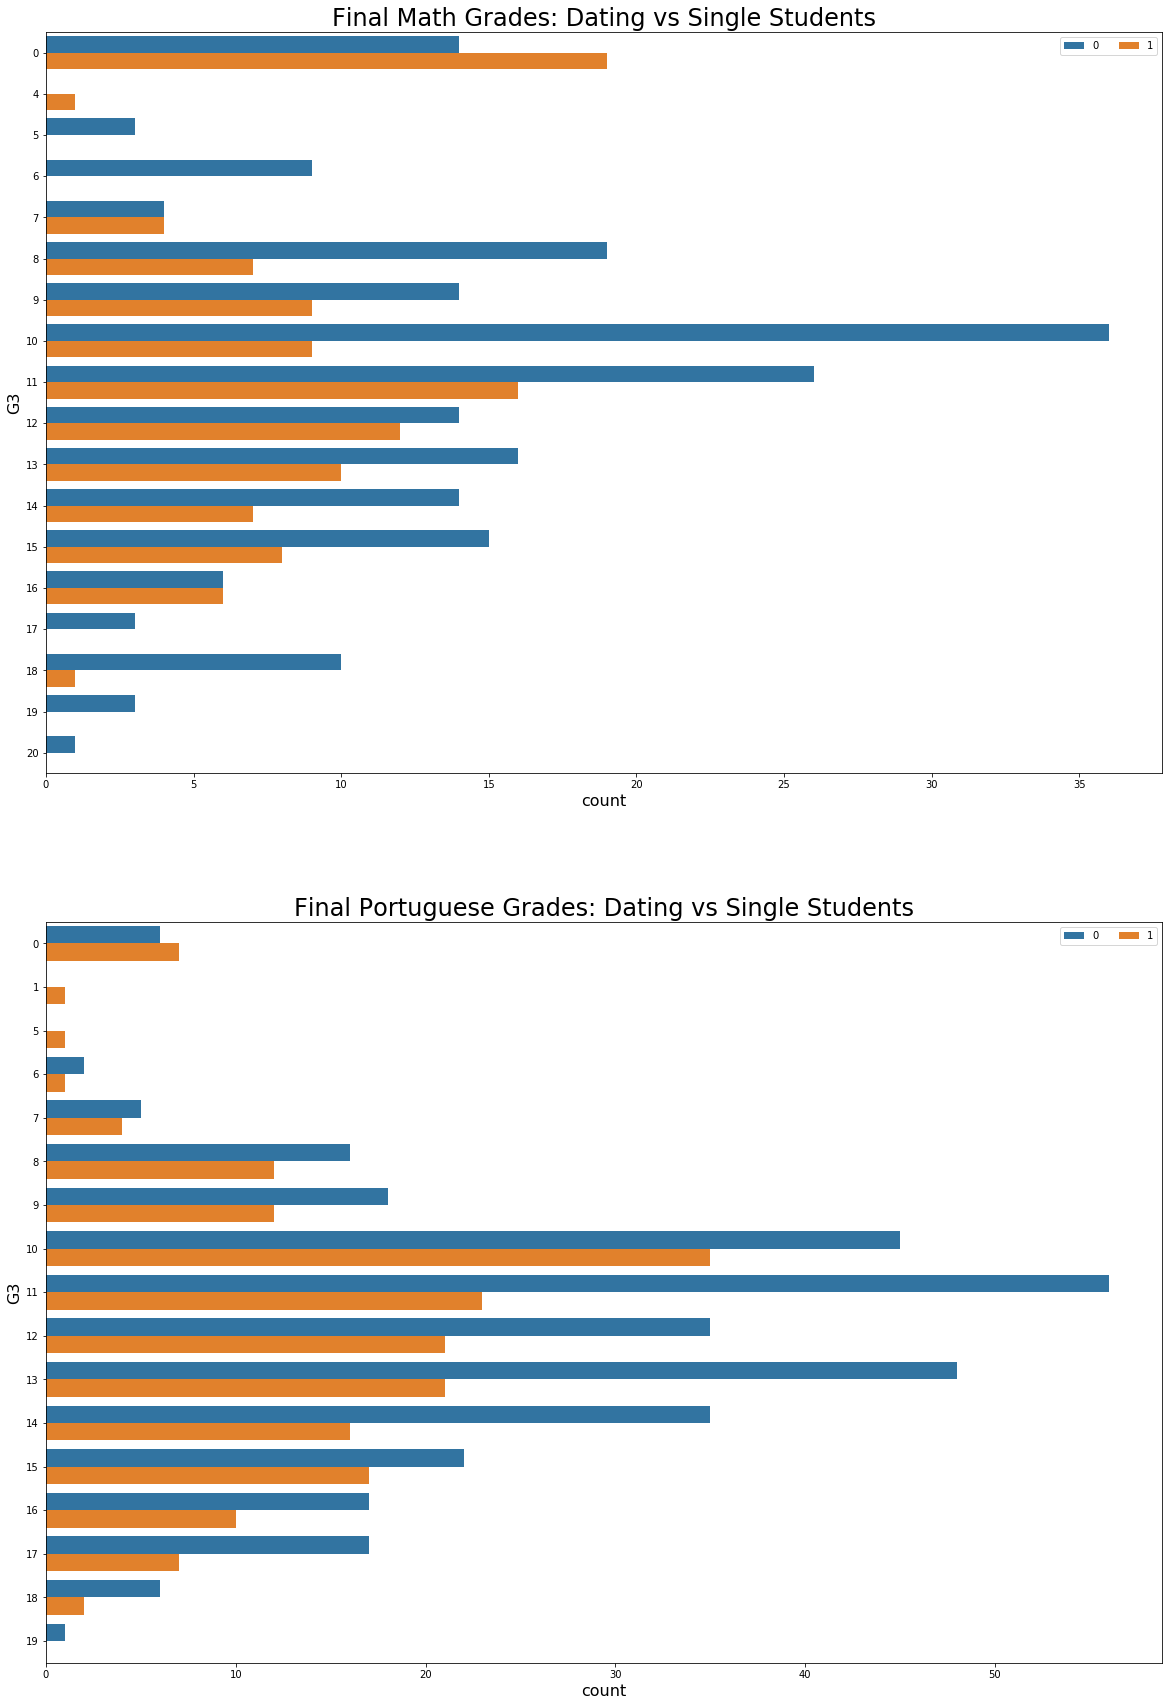

NameError: name 'groupname' is not defined

In [51]:
save_fig = True

fig = plt.figure(figsize=(20,30))


ax1 = fig.add_subplot(211)
ax1.set_title("Final Math Grades: Dating vs Single Students", 
             fontsize=24)
ax1.set_xlabel('Counts', fontsize=16)
ax1.set_ylabel('Final Math Grade', fontsize=16)
sns.countplot(y='G3', hue='romantic', data=m_train)
ax1.legend(loc='best', 
          ncol=2)


ax2 = fig.add_subplot(212)
ax2.set_title("Final Portuguese Grades: Dating vs Single Students", 
             fontsize=24)
ax2.set_xlabel('Counts', fontsize=16)
ax2.set_ylabel('Final Portuguese Grade', fontsize=16)
sns.countplot(y='G3', hue='romantic', data=p_train)
ax2.legend(loc='best', 
          ncol=2)


plt.show()

if save_fig:
    file_name = '../images/m_p_distributions.png'.format(groupname)
    fig.savefig(file_name)


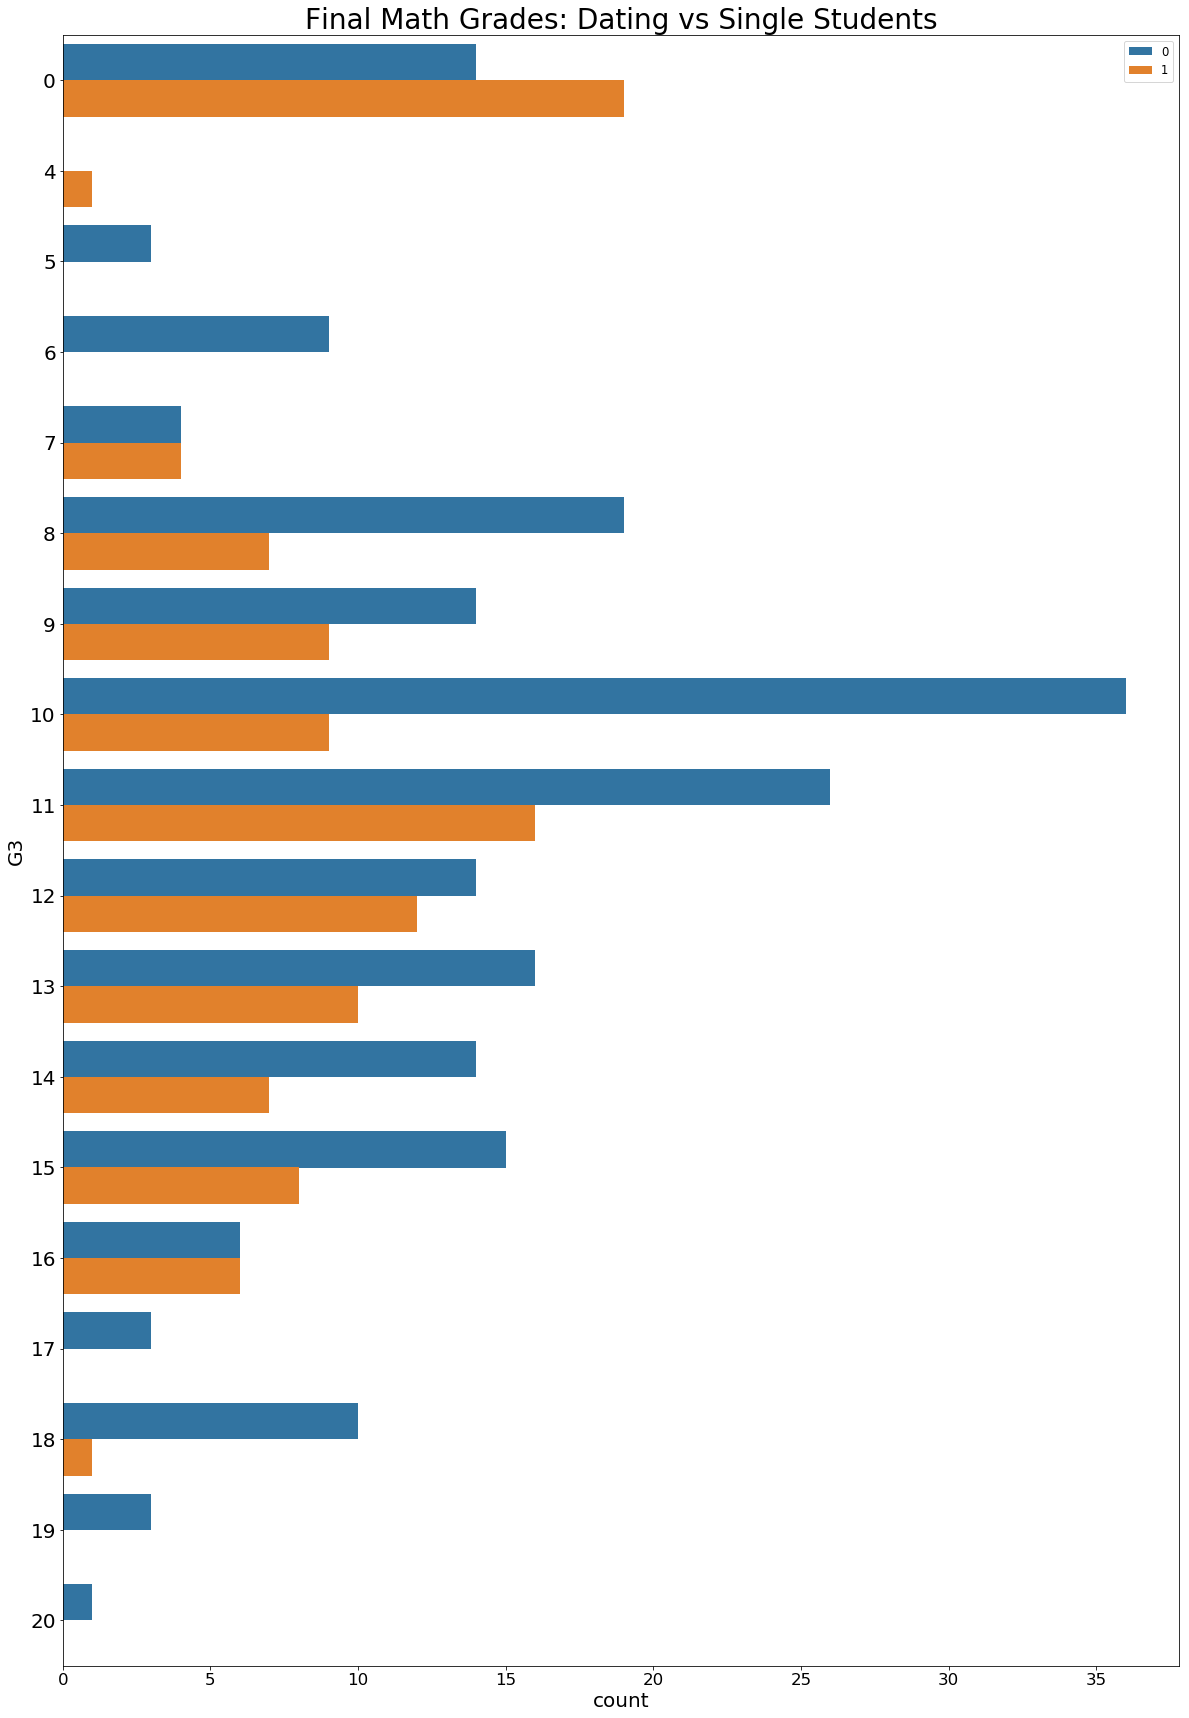

In [202]:
fig = plt.figure(figsize=(20,30))


ax1 = fig.add_subplot(111)
ax1.set_title("Final Math Grades: Dating vs Single Students", 
             fontsize=28)
ax1.set_xlabel('Counts', fontsize=20)
ax1.set_ylabel('Final Math Grade', fontsize=20)
sns.countplot(y='G3', hue='romantic', data=m_train)
ax1.legend(loc='best', 
          ncol=1)

plt.savefig('../images/m_g3_dist.png')

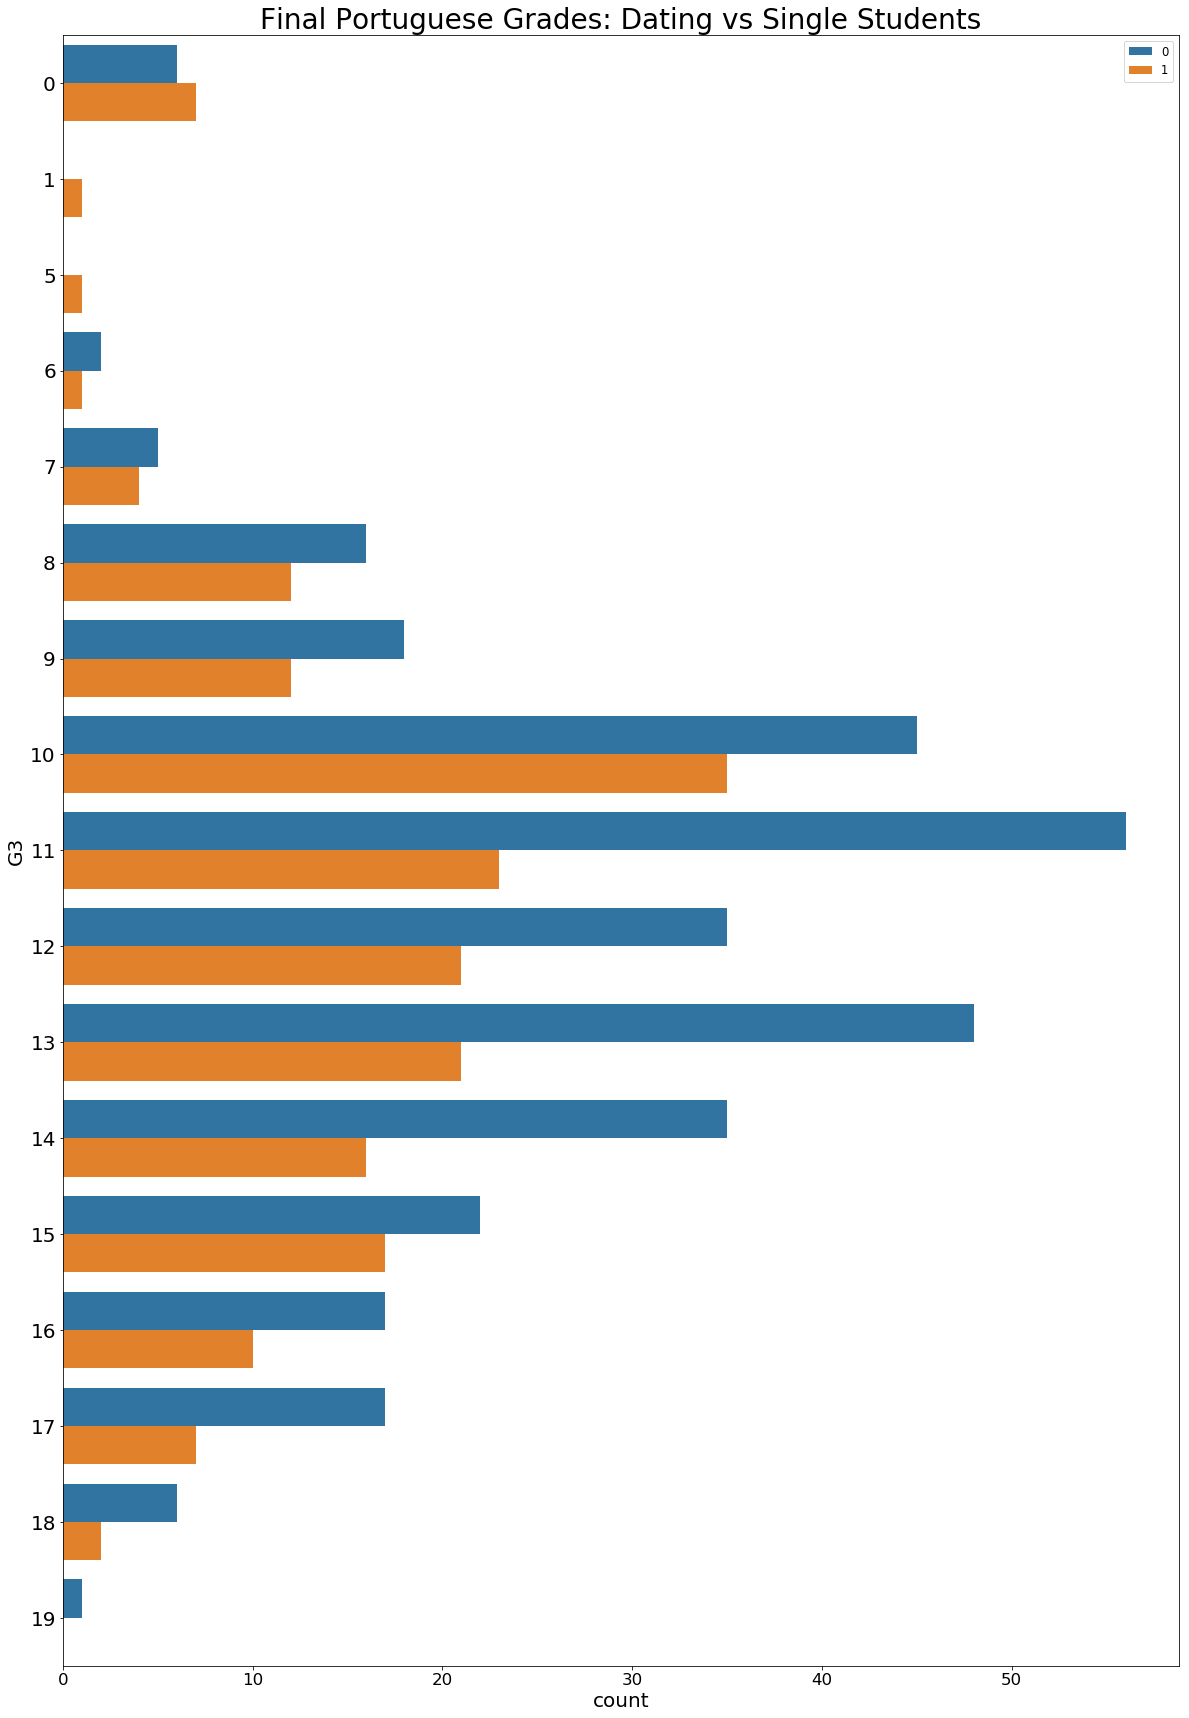

In [203]:
fig = plt.figure(figsize=(20,30))


ax1 = fig.add_subplot(111)
ax1.set_title("Final Portuguese Grades: Dating vs Single Students", 
             fontsize=28)
ax1.set_xlabel('Counts', fontsize=20)
ax1.set_ylabel('Final Portuguese Grade', fontsize=20)
sns.countplot(y='G3', hue='romantic', data=p_train)
ax1.legend(loc='best', 
          ncol=1)

plt.savefig('../images/p_g3_dist.png')

In [ ]:
X = X_embedded_3[:,0]
y = X_embedded_3[:,1]
z = X_embedded_3[:,2]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

ax.set_title("Doc2Vec Representations of Annotations & Lyrics (3D)", fontsize=18)
size = 200
n_docs = X_embedded_3.shape[0]
n_pairs = n_docs / 2
for idx in range(n_docs):
    is_odd_idx = idx % 2 != 0
    alpha = 0.6 if is_odd_idx else 0.3
    ax.scatter(X[idx], y[idx], z[idx], s=size, alpha=alpha, c=colors_dict[idx], label=pair_labels_dict[idx])
    if is_odd_idx:
        label_text = "Distance between {0} pair".format(pair_labels_dict[idx])
        line_format = ':' + colors_dict[idx][:1]
        plt.plot([X[idx-1], X[idx]], [y[idx-1], y[idx]], [z[idx-1], z[idx]], line_format, label=label_text);
ax.legend(loc='upper center', ncol=int(n_pairs), markerscale=0.5, bbox_to_anchor=(0.5, -0.15))
plt.show()
if save_fig:
    file_name = '../images/{}_3d_tsne_plot.png'.format(groupname)
    fig.savefig(file_name)

In [29]:
pplot_math = m_df[['age', 'absences', 'G1', 'G2', 'G3', 'romantic']]
pplot_port = p_df[['age', 'absences', 'G1', 'G2', 'G3', 'romantic']]

In [32]:
m_rom = ['yes' if rom == 1 else 'no' for rom in pplot_math['romantic']]
p_rom = ['yes' if rom == 1 else 'no' for rom in pplot_port['romantic']]

pplot_math['relationship'] = m_rom
pplot_port['relationship'] = p_rom

In [34]:
pplot_math.drop('romantic', axis=1, inplace=True)
pplot_port.drop('romantic', axis=1, inplace=True)

In [35]:
pplot_math.head()

,age,absences,G1,G2,G3,relationship
0,18,6,5,6,6,no
1,17,4,5,5,6,no
2,15,10,7,8,10,no
3,15,2,15,14,15,yes
4,16,4,6,10,10,no


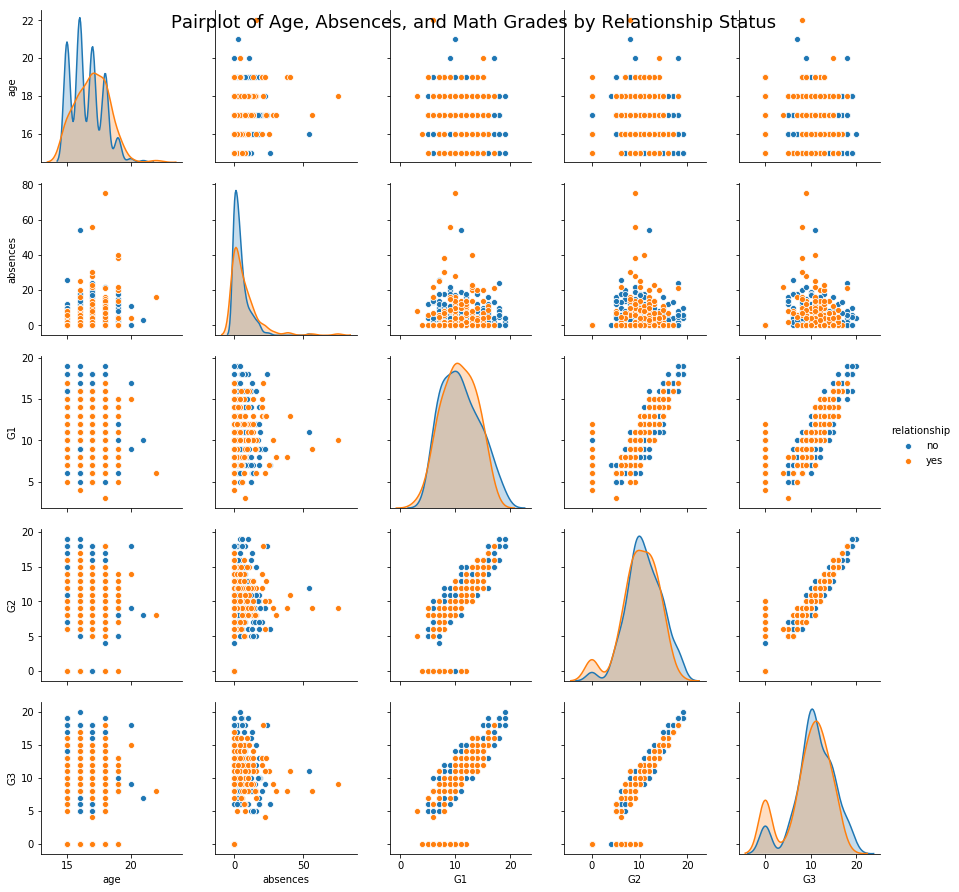

In [41]:
# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111)


sns.pairplot(pplot_math, hue='relationship')

plt.suptitle('Pairplot of Age, Absences, and Math Grades by Relationship Status', 
             size = 18);

plt.savefig('../images/math_pairplot.png')

# ax.legend(loc='best', markerscale=0.5, bbox_to_anchor=(0.5, -0.15))
# plt.show()

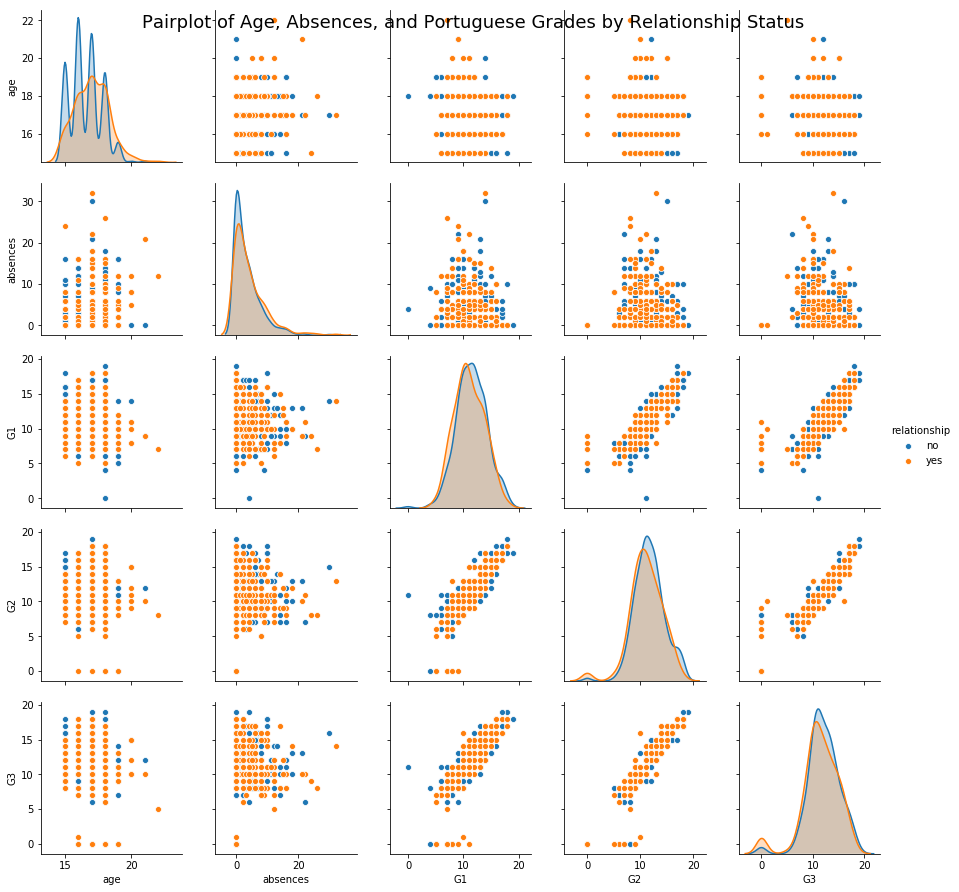

In [42]:
sns.pairplot(pplot_port, hue='relationship')

plt.suptitle('Pairplot of Age, Absences, and Portuguese Grades by Relationship Status', 
             size = 18);

plt.savefig('../images/port_pairplot.png')


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrices
import statsmodels.api as sm
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

In [11]:
def k_fold_CV(X, y, desc, n_folds = 5, cw = 'balanced', threshold = 0.5):
    skf = StratifiedKFold(n_splits=n_folds, shuffle=False)
    auc_test = []
    accuracy_test = []
    precision_test = []
    recall_test = []
    f1_score_test = []
    auc_train = []
    accuracy_train = []
    precision_train = []
    recall_train = []
    f1_score_train = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        model = LogisticRegression(class_weight=cw)
        model.fit(X_train, y_train)
        probs = model.predict_proba(X_test)[:, 1]
        probabilities = np.where(probs >= threshold, 1, 0)
        probs_train = model.predict_proba(X_train)[:, 1]
        probabilities_train = np.where(probs_train >= threshold, 1, 0)
        auc_test.append(metrics.roc_auc_score(y_test, probs))
        accuracy_test.append(metrics.accuracy_score(y_test, probabilities))
        precision_test.append(metrics.precision_score(y_test, probabilities))
        recall_test.append(metrics.recall_score(y_test, probabilities))
        f1_score_test.append(metrics.f1_score(y_test, probabilities))
        auc_train.append(metrics.roc_auc_score(y_train, probs_train))
        accuracy_train.append(metrics.accuracy_score(y_train, probabilities_train))
        precision_train.append(metrics.precision_score(y_train, probabilities_train))
        recall_train.append(metrics.recall_score(y_train, probabilities_train))
        f1_score_train.append(metrics.f1_score(y_train, probabilities_train))
    return [np.mean(auc_test), np.mean(accuracy_test), np.mean(precision_test),
            np.mean(recall_test), np.mean(f1_score_test), np.mean(auc_train), np.mean(accuracy_train), 
            np.mean(precision_train), np.mean(recall_train), np.mean(f1_score_train), desc]

In [12]:
# TARGET ALWAYS 'ROMANTIC'
y_col = 'romantic'

# FULL MODEL
X_cols1 = ['age', 'absences', 'G3', 'school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'Medu_1', 'Medu_2', 'Medu_3', 'Medu_4', 'Fedu_1', 'Fedu_2', 'Fedu_3', 'Fedu_4', 'Mjob_at_home', 'Mjob_health', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_reputation', 'guardian_father', 'guardian_mother', 'traveltime_2', 'traveltime_3', 'traveltime_4', 'studytime_2', 'studytime_3', 'studytime_4', 'failures_1', 'failures_2', 'failures_3', 'famrel_2', 'famrel_3', 'famrel_4', 'famrel_5', 'freetime_2', 'freetime_3', 'freetime_4', 'freetime_5', 'goout_2', 'goout_3', 'goout_4', 'goout_5', 'Dalc_2', 'Dalc_3', 'Dalc_4', 'Dalc_5', 'Walc_2', 'Walc_3', 'Walc_4', 'Walc_5', 'health_2', 'health_3', 'health_4', 'health_5']

# SMALLER MODEL - TAKING OUT SOME SOCIAL DEMS
X_cols2 = ['age', 'absences', 'G3', 'school', 'sex', 'address', 'famsize', 'schoolsup', 'activities', 'higher', 'reason_course', 'reason_home', 'reason_reputation', 'studytime_2', 'studytime_3', 'studytime_4', 'failures_1', 'failures_2', 'failures_3', 'freetime_2', 'freetime_3', 'freetime_4', 'freetime_5', 'health_2', 'health_3', 'health_4', 'health_5']

# SMALLEST MODEL - TAKING OUT EVERYTHING EXCEPT ACADEMIC OUTCOMES
X_cols3 = ['absences', 'G3', 'activities', 'higher', 'studytime_2', 'studytime_3', 'studytime_4', 'failures_1', 'failures_2', 'failures_3', 'freetime_2', 'freetime_3', 'freetime_4', 'freetime_5', 'health_2', 'health_3', 'health_4', 'health_5']

In [13]:
# Create X and y training dataframes for each group...
X_m1 = m_train[X_cols1]
X_p1 = p_train[X_cols1]

X_m2 = m_train[X_cols2]
X_p2 = p_train[X_cols2]

X_m3 = m_train[X_cols3]
X_p3 = p_train[X_cols3]

y_m = m_train[y_col]
y_p = p_train[y_col]

print(X_m1.shape)
print(X_p1.shape)
print(X_m2.shape)
print(X_p2.shape)
print(X_m3.shape)
print(X_p3.shape)

(316, 69)
(519, 69)
(316, 27)
(519, 27)
(316, 18)
(519, 18)


In [14]:
# Put models into lists so we can iterate through easily...
m_models = [(X_m1, 'all features'), (X_m2, 'minimal social features'), (X_m3, 'only educ outcome features')]
p_models = [(X_p1, 'all features'), (X_p2, 'minimal social features'), (X_p3, 'only educ outcome features')]

In [15]:
m_cv_results = dict()
p_cv_results = dict()

for model, m_desc in m_models:
    model_metrics = k_fold_CV(model, y_m, desc=m_desc, n_folds = 5, cw = 'balanced', threshold = 0.5)
    m_cv_results[m_desc] = model_metrics

for model, p_desc in p_models:
    model_metrics = k_fold_CV(model, y_p, desc=p_desc, n_folds = 5, cw = 'balanced', threshold = 0.5)
    p_cv_results[p_desc] = model_metrics   

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

In [16]:
m_acc_scores = []
for key, value in m_cv_results.items():
    m_acc_scores.append(value[1])

print(m_acc_scores)
print(max(m_acc_scores))

[0.531443612391193, 0.5662218381976447, 0.5572564644137225]
0.5662218381976447


In [17]:
m_f1_scores = []
for key, value in m_cv_results.items():
    m_f1_scores.append(value[4])

print(m_f1_scores)
print(max(m_f1_scores))

[0.40523694475062255, 0.46106187719090946, 0.4537886857702941]
0.46106187719090946


In [18]:
p_f1_scores = []
for key, value in p_cv_results.items():
    p_f1_scores.append(value[4])

print(p_f1_scores)
print(max(p_f1_scores))

[0.4892309374239069, 0.5012008374255044, 0.501140064132499]
0.5012008374255044


In [19]:
print(m_cv_results)

{'all features': [0.5175007918910357, 0.531443612391193, 0.35942705174156786, 0.4675324675324675, 0.40523694475062255, 0.8311103557385235, 0.740505905141304, 0.5996023567548862, 0.7454806687565307, 0.6643651149280452, 'all features'], 'minimal social features': [0.603874986801816, 0.5662218381976447, 0.40347981923016984, 0.5502164502164503, 0.46106187719090946, 0.7349246515843941, 0.6653220224942238, 0.5108248578818024, 0.6651253918495298, 0.5775314142013633, 'minimal social features'], 'only educ outcome features': [0.6012564671101257, 0.5572564644137225, 0.3980672100672101, 0.5329004329004329, 0.4537886857702941, 0.7032536048058482, 0.6424188330213664, 0.48573108674399634, 0.6284482758620691, 0.5477568642381065, 'only educ outcome features']}


In [20]:
m_scores = []
for X_m, desc in m_models:
    m_cross_val_model = LogisticRegression(class_weight='balanced', random_state=0)
    scores = cross_val_score(m_cross_val_model, X_m, 
             y_m, scoring='f1', cv=3)
    m_scores.append(np.mean(scores))
    print(desc, np.mean(scores))
print(max(m_scores))

all features 0.3874402782555517
minimal social features 0.4444755767255067
only educ outcome features 0.4782535472190645
0.4782535472190645


/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

In [21]:
p_scores = []
for X_p, desc in p_models:
    p_cross_val_model = LogisticRegression(class_weight='balanced', random_state=0)
    scores = cross_val_score(p_cross_val_model, X_p, 
             y_p, scoring='f1', cv=3)
    p_scores.append(np.mean(scores))
    print(desc, np.mean(scores))
print(max(p_scores))

all features 0.46723591755426597
minimal social features 0.5081237906558974
only educ outcome features 0.4899591149591149
0.5081237906558974


/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

In [64]:
p_scores = []
for X_p, desc in p_models:
    p_cross_val_model = LogisticRegression(class_weight='balanced', random_state=0)
    scores = cross_val_score(p_cross_val_model, X_p, 
             y_p, scoring='precision', cv=3)
    p_scores.append(np.mean(scores))
    print(desc, np.mean(scores))
print(max(p_scores))

all features 0.40823171607729763
minimal social features 0.4585220272045564
only educ outcome features 0.4480413105413105
0.4585220272045564


/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

In [72]:
# penalty specifies the norm in the penalization
penalty = ['l1', 'l2']
# C is the inverese of regularization parameter
C = np.logspace(0, 4, 10)
# thresh is the threshold at which we choose the labels - let's try 10 
# thresh = np.linspace(0, 1, 10)
random_state=[0]
# creating a dictionary of hyperparameters
hyperparameters = dict(C=C, penalty=penalty, random_state=random_state)

In [73]:
model = LogisticRegression(class_weight='balanced', random_state=0)
model.fit(X_m3, y_m)

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [74]:
clf = GridSearchCV(estimator = model, param_grid = hyperparameters, 
                   cv=5)
best_model = clf.fit(X_m3, y_m)
print('Best Penalty:', best_model.best_estimator_.get_params() ['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
# print('Best thresh:', best_model.best_estimator_.get_params()['C'])

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

Best Penalty: l1
Best C: 7.742636826811269


/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

In [75]:
m_best_penalty = best_model.best_estimator_.get_params() ['penalty']
m_best_c = best_model.best_estimator_.get_params()['C']

In [76]:
p_model = LogisticRegression(class_weight='balanced', random_state=0)
p_model.fit(X_p3, y_p)

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [77]:
clf = GridSearchCV(estimator = model, param_grid = hyperparameters, 
                   cv=5)
best_model = clf.fit(X_p3, y_p)

p_best_penalty = best_model.best_estimator_.get_params() ['penalty']
p_best_c = best_model.best_estimator_.get_params()['C']

print('Best Penalty:', p_best_penalty)
print('Best C:', p_best_c)
# print('Best thresh:', best_model.best_estimator_.get_params()['C'])

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

Best Penalty: l2
Best C: 1.0


/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [80]:
print('M Best Penalty:', m_best_penalty)
print('M Best C:', m_best_c)
print('P Best Penalty:', p_best_penalty)
print('P Best C:', p_best_c)

M Best Penalty: l1
M Best C: 7.742636826811269
P Best Penalty: l2
P Best C: 1.0


In [82]:
X_test_m = m_holdout[X_cols3]
X_test_p = p_holdout[X_cols3]

y_test_m = m_holdout[y_col]
y_test_p = p_holdout[y_col]

print(X_test_m.shape)
print(X_test_p.shape)
print(y_test_m.shape)
print(y_test_p.shape)

(79, 18)
(130, 18)
(79,)
(130,)


In [83]:
# FINAL FITTING, YAY

m_model = LogisticRegression(penalty=m_best_penalty, C=m_best_c, class_weight='balanced', random_state=0).fit(X_m3, y_m)

m_probs = m_model.predict_proba(X_test_m)[:, 1]
threas = 0.7

m_pred = np.where(m_probs >= threas, 1, 0)

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [84]:
m_coeffs = m_model.coef_
m_coeffs

array([[ 0.03844227, -0.06022414,  0.1327803 , -1.09990742,  0.97666176,
         1.13864497, -0.20856112, -0.18669789,  1.22410631, -0.20419155,
         0.93455016,  0.36698336,  0.52185713,  1.10451702, -0.13674141,
         0.23300969, -0.20068502,  0.12231123]])

In [85]:
m_results = dict()
for idx in range(len(m_coeffs[0])):
    m_results[X_cols3[idx]] = m_coeffs[0][idx].round(3)
print(m_results)

{'absences': 0.038, 'G3': -0.06, 'activities': 0.133, 'higher': -1.1, 'studytime_2': 0.977, 'studytime_3': 1.139, 'studytime_4': -0.209, 'failures_1': -0.187, 'failures_2': 1.224, 'failures_3': -0.204, 'freetime_2': 0.935, 'freetime_3': 0.367, 'freetime_4': 0.522, 'freetime_5': 1.105, 'health_2': -0.137, 'health_3': 0.233, 'health_4': -0.201, 'health_5': 0.122}


In [86]:
p_model = LogisticRegression(penalty=p_best_penalty, C=p_best_c, class_weight='balanced', random_state=0).fit(X_p3, y_p)

p_probs = p_model.predict_proba(X_test_p)[:, 1]
threas = 0.7

p_pred = np.where(p_probs >= threas, 1, 0)

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [87]:
p_coeffs = p_model.coef_
p_coeffs

array([[ 0.04386247, -0.03880631,  0.23177005, -0.6288086 ,  0.637397  ,
         1.01823098, -0.61014284,  0.57436158,  0.11103364, -0.111657  ,
         0.64579874,  0.262338  ,  0.05379911,  0.66856777, -0.28960169,
        -0.21823975, -0.50596177, -0.00698944]])

In [110]:
len(p_coeffs[0])

18

In [88]:
p_results = dict()
for idx in range(len(p_coeffs[0])):
    p_results[X_cols3[idx]] = p_coeffs[0][idx].round(3)
print(p_results)

{'absences': 0.044, 'G3': -0.039, 'activities': 0.232, 'higher': -0.629, 'studytime_2': 0.637, 'studytime_3': 1.018, 'studytime_4': -0.61, 'failures_1': 0.574, 'failures_2': 0.111, 'failures_3': -0.112, 'freetime_2': 0.646, 'freetime_3': 0.262, 'freetime_4': 0.054, 'freetime_5': 0.669, 'health_2': -0.29, 'health_3': -0.218, 'health_4': -0.506, 'health_5': -0.007}


In [101]:
list(p_results.keys())

['absences',
 'G3',
 'activities',
 'higher',
 'studytime_2',
 'studytime_3',
 'studytime_4',
 'failures_1',
 'failures_2',
 'failures_3',
 'freetime_2',
 'freetime_3',
 'freetime_4',
 'freetime_5',
 'health_2',
 'health_3',
 'health_4',
 'health_5']

In [107]:
coeffs = pd.DataFrame(list(p_results.keys()))
coeffs.columns = ['feature']
coeffs

,feature
0,absences
1,G3
2,activities
3,higher
4,studytime_2
5,studytime_3
6,studytime_4
7,failures_1
8,failures_2
9,failures_3


In [111]:
coeffs['m_coeffs'] = m_coeffs[0]
coeffs['p_coeffs'] = p_coeffs[0]
coeffs

,feature,m_coeffs,p_coeffs
0,absences,0.038442,0.043862
1,G3,-0.060224,-0.038806
2,activities,0.132780,0.231770
3,higher,-1.099907,-0.628809
4,studytime_2,0.976662,0.637397
5,studytime_3,1.138645,1.018231
6,studytime_4,-0.208561,-0.610143
7,failures_1,-0.186698,0.574362
8,failures_2,1.224106,0.111034
9,failures_3,-0.204192,-0.111657


In [117]:
coeffs.index = list(p_results.keys())
coeffs.drop('feature', axis=1, inplace=True)
coeffs

KeyError: "['feature'] not found in axis"

In [119]:
coeffs.columns = ['math', 'portuguese']
coeffs

,math,portuguese
absences,0.038442,0.043862
G3,-0.060224,-0.038806
activities,0.132780,0.231770
higher,-1.099907,-0.628809
studytime_2,0.976662,0.637397
studytime_3,1.138645,1.018231
studytime_4,-0.208561,-0.610143
failures_1,-0.186698,0.574362
failures_2,1.224106,0.111034
failures_3,-0.204192,-0.111657


In [113]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [204]:
mpl.rcParams.update({
    'font.size'           : 20.0,
    'axes.titlesize'      : 'large',
    'axes.labelsize'      : 'medium',
    'xtick.labelsize'     : 'small',
    'ytick.labelsize'     : 'medium',
    'legend.fontsize'     : 'xx-small',
})

# data = {'Binge Drinking': [-17.0208, -6.5088, -10.0818, 0.9218, -0.8901, -4.1470],
#                 'Smoking' : [-3.1133, 12.0400, 16.5517,0.3347, 3.8534, 6.2355 ],
#                 'Sleep < 7hrs': [7.5038, 10.9263, 12.2285, -7.2640, 2.2277, 3.0339 ]}
# labels = ['% Female',
#             '% Edu < HS',
#             '% IPR < 1.5',
#             '% Commute < 30',
#             '% Depart before 8',
#             '% Insured']

# df = pd.DataFrame.from_dict(data)
# # df['Dropped'] = df.Initial-df.Final
# # df['Drop %'] = df.Dropped/df.Initial*100
# df.index = labels

# df.columns = ['Binge Drinking', 'Smoking', 'Sleep < 7hrs']
# print('\n')


# fig = plt.figure(figsize=(10,10))
# fig.add_subplot(111)
# plt.figure(figsize=(10,10))
ax = coeffs.T.plot(kind='bar')
# ax.bar(coeffs.T)
# ax = sns.violinplot(x=states_sum, orient='v')


# plt.title('Count of State Tracts')
# ax.set(xlabel='', ylabel='')


ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
ax.set(ylabel='Coefficients')
ax.legend(loc='upper center', ncol=2, markerscale=0.5, bbox_to_anchor=(1.8, 1))

# ax.legend(loc='best', ncol=2, fancybox=False, shadow=False)
plt.tight_layout()
plt.show()
plt.savefig('../images/coeffs_bar.png')
plt.close()

TypeError: Empty 'DataFrame': no numeric data to plot

In [156]:
coeffs['math_delta_odds'] = np.exp(coeffs['math'])
coeffs

,math,portuguese,math_delta_odds
absences,0.038442,0.043862,1.039191
G3,-0.060224,-0.038806,0.941553
activities,0.132780,0.231770,1.141999
higher,-1.099907,-0.628809,0.332902
studytime_2,0.976662,0.637397,2.655576
studytime_3,1.138645,1.018231,3.122534
studytime_4,-0.208561,-0.610143,0.811751
failures_1,-0.186698,0.574362,0.829694
failures_2,1.224106,0.111034,3.401125
failures_3,-0.204192,-0.111657,0.815306


In [158]:
coeffs['port_delta_odds'] = np.exp(coeffs['portuguese'])
coeffs

,math,portuguese,math_delta_odds,port_delta_odds
absences,0.038442,0.043862,1.039191,1.044839
G3,-0.060224,-0.038806,0.941553,0.961937
activities,0.132780,0.231770,1.141999,1.260830
higher,-1.099907,-0.628809,0.332902,0.533227
studytime_2,0.976662,0.637397,2.655576,1.891551
studytime_3,1.138645,1.018231,3.122534,2.768293
studytime_4,-0.208561,-0.610143,0.811751,0.543273
failures_1,-0.186698,0.574362,0.829694,1.775996
failures_2,1.224106,0.111034,3.401125,1.117432
failures_3,-0.204192,-0.111657,0.815306,0.894351


In [160]:
coeffs['math_perc_dodds'] = coeffs['math_delta_odds'] - 1
coeffs['port_perc_dodds'] = coeffs['port_delta_odds'] - 1
coeffs

,math,portuguese,math_delta_odds,port_delta_odds,math_perc_dodds,port_perc_dodds
absences,0.038442,0.043862,1.039191,1.044839,0.039191,0.044839
G3,-0.060224,-0.038806,0.941553,0.961937,-0.058447,-0.038063
activities,0.132780,0.231770,1.141999,1.260830,0.141999,0.260830
higher,-1.099907,-0.628809,0.332902,0.533227,-0.667098,-0.466773
studytime_2,0.976662,0.637397,2.655576,1.891551,1.655576,0.891551
studytime_3,1.138645,1.018231,3.122534,2.768293,2.122534,1.768293
studytime_4,-0.208561,-0.610143,0.811751,0.543273,-0.188249,-0.456727
failures_1,-0.186698,0.574362,0.829694,1.775996,-0.170306,0.775996
failures_2,1.224106,0.111034,3.401125,1.117432,2.401125,0.117432
failures_3,-0.204192,-0.111657,0.815306,0.894351,-0.184694,-0.105649


/Users/tsandefer/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


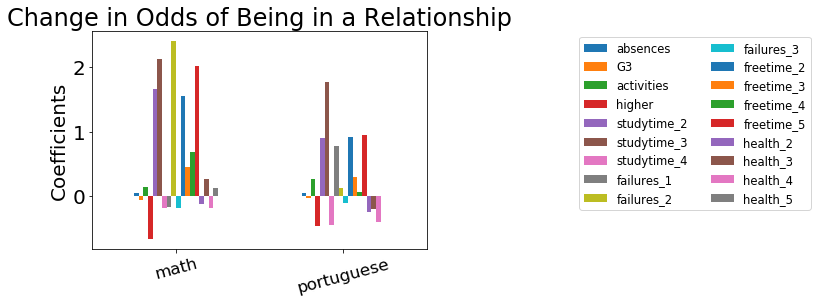

In [165]:
ax = coeffs[['math_perc_dodds','port_perc_dodds']].T.plot(kind='bar')

plt.title('Change in Odds of Being in a Relationship')
ax.set_xticklabels(['math', 'portuguese'], rotation=15)
ax.set(ylabel='Coefficients')

ax.legend(loc='upper center', ncol=2, markerscale=0.5, bbox_to_anchor=(1.8, 1))

# ax.legend(loc='best', ncol=2, fancybox=False, shadow=False)
plt.tight_layout()
plt.show()
plt.savefig('../images/delta_odds_bar.png')
plt.close()

In [166]:
m_model.pvals_

AttributeError: 'LogisticRegression' object has no attribute 'pvals_'

In [167]:
from sklearn.feature_selection import chi2

m_scores, m_pvalues = chi2(X_m3, y_m)
p_scores, p_pvalues = chi2(X_p3, y_p)

print(m_pvalues)
print(p_pvalues)

[2.93424145e-20 1.85177721e-03 7.56746200e-01 6.44074997e-01
 1.54855718e-01 2.53145237e-01 5.13979212e-02 6.43034722e-01
 7.63818740e-03 7.63440384e-01 4.12730542e-01 5.16445651e-01
 9.46550330e-01 5.53719312e-01 9.79351573e-01 4.47093854e-01
 3.83146610e-01 8.47073824e-01]
[8.00245417e-10 4.70997137e-02 5.13753852e-01 4.32188640e-01
 3.16987041e-01 7.71197546e-02 3.24333291e-02 2.53411911e-02
 4.18737074e-01 8.23841746e-01 3.16060430e-01 8.96385101e-01
 3.49215064e-01 1.58153587e-01 7.95870892e-01 8.40401908e-01
 1.47542883e-01 4.70406770e-01]


In [168]:
m_pvalues[m_pvalues < 0.01]

array([2.93424145e-20, 1.85177721e-03, 7.63818740e-03])

In [169]:
p_pvalues[p_pvalues < 0.01]

array([8.00245417e-10])

In [170]:
m_pvalues[m_pvalues < 0.05]

array([2.93424145e-20, 1.85177721e-03, 7.63818740e-03])

In [179]:
p_pvalues[p_pvalues < 0.1]

array([8.00245417e-10, 4.70997137e-02, 3.24333291e-02, 2.53411911e-02])

In [180]:
feats = list(p_results.keys())
len(feats)

18

In [183]:
coeffs['m_pvals'] = m_pvalues
coeffs['p_pvals'] = p_pvalues
coeffs

,math,portuguese,math_delta_odds,port_delta_odds,math_perc_dodds,port_perc_dodds,m_pvals,p_pvals
absences,0.038442,0.043862,1.039191,1.044839,0.039191,0.044839,2.934241e-20,8.002454e-10
G3,-0.060224,-0.038806,0.941553,0.961937,-0.058447,-0.038063,1.851777e-03,4.709971e-02
activities,0.132780,0.231770,1.141999,1.260830,0.141999,0.260830,7.567462e-01,5.137539e-01
higher,-1.099907,-0.628809,0.332902,0.533227,-0.667098,-0.466773,6.440750e-01,4.321886e-01
studytime_2,0.976662,0.637397,2.655576,1.891551,1.655576,0.891551,1.548557e-01,3.169870e-01
studytime_3,1.138645,1.018231,3.122534,2.768293,2.122534,1.768293,2.531452e-01,7.711975e-02
studytime_4,-0.208561,-0.610143,0.811751,0.543273,-0.188249,-0.456727,5.139792e-02,3.243333e-02
failures_1,-0.186698,0.574362,0.829694,1.775996,-0.170306,0.775996,6.430347e-01,2.534119e-02
failures_2,1.224106,0.111034,3.401125,1.117432,2.401125,0.117432,7.638187e-03,4.187371e-01
failures_3,-0.204192,-0.111657,0.815306,0.894351,-0.184694,-0.105649,7.634404e-01,8.238417e-01


In [187]:
m_signif10 = coeffs['m_pvals'] < 0.1
p_signif10 = coeffs['p_pvals'] < 0.1

m_signif5 = coeffs['m_pvals'] < 0.05
p_signif5 = coeffs['p_pvals'] < 0.05

m_signif1 = coeffs['m_pvals'] < 0.01
p_signif1 = coeffs['p_pvals'] < 0.01

coeffs[m_signif10]['m_pvals'].index

Index(['absences', 'G3', 'studytime_4', 'failures_2'], dtype='object')

In [190]:
coeffs['m_signif10'] = m_signif10
coeffs['p_signif10'] = p_signif10

coeffs['m_signif5'] = m_signif5
coeffs['p_signif5'] = p_signif5

coeffs['m_signif1'] = m_signif1
coeffs['p_signif1'] = p_signif1

coeffs

,math,portuguese,math_delta_odds,port_delta_odds,math_perc_dodds,port_perc_dodds,m_pvals,p_pvals,m_signif10,p_signif10,m_signif5,p_signif5,m_signif1,p_signif1
absences,0.038442,0.043862,1.039191,1.044839,0.039191,0.044839,2.934241e-20,8.002454e-10,True,True,True,True,True,True
G3,-0.060224,-0.038806,0.941553,0.961937,-0.058447,-0.038063,1.851777e-03,4.709971e-02,True,True,True,True,True,False
activities,0.132780,0.231770,1.141999,1.260830,0.141999,0.260830,7.567462e-01,5.137539e-01,False,False,False,False,False,False
higher,-1.099907,-0.628809,0.332902,0.533227,-0.667098,-0.466773,6.440750e-01,4.321886e-01,False,False,False,False,False,False
studytime_2,0.976662,0.637397,2.655576,1.891551,1.655576,0.891551,1.548557e-01,3.169870e-01,False,False,False,False,False,False
studytime_3,1.138645,1.018231,3.122534,2.768293,2.122534,1.768293,2.531452e-01,7.711975e-02,False,True,False,False,False,False
studytime_4,-0.208561,-0.610143,0.811751,0.543273,-0.188249,-0.456727,5.139792e-02,3.243333e-02,True,True,False,True,False,False
failures_1,-0.186698,0.574362,0.829694,1.775996,-0.170306,0.775996,6.430347e-01,2.534119e-02,False,True,False,True,False,False
failures_2,1.224106,0.111034,3.401125,1.117432,2.401125,0.117432,7.638187e-03,4.187371e-01,True,False,True,False,True,False
failures_3,-0.204192,-0.111657,0.815306,0.894351,-0.184694,-0.105649,7.634404e-01,8.238417e-01,False,False,False,False,False,False


In [191]:
m_signif10_feats = list(coeffs[m_signif10]['m_pvals'].index)
m_signif5_feats = list(coeffs[m_signif5]['m_pvals'].index)
m_signif1_feats = list(coeffs[m_signif1]['m_pvals'].index)

p_signif10_feats = list(coeffs[p_signif10]['p_pvals'].index)
p_signif5_feats = list(coeffs[p_signif5]['p_pvals'].index)
p_signif1_feats = list(coeffs[p_signif1]['p_pvals'].index)

In [194]:
print(m_signif10_feats)
print(m_signif5_feats)
print(m_signif1_feats)
print('\n')
print(p_signif10_feats)
print(p_signif5_feats)
print(p_signif1_feats)

['absences', 'G3', 'studytime_4', 'failures_2']
['absences', 'G3', 'failures_2']
['absences', 'G3', 'failures_2']


['absences', 'G3', 'studytime_3', 'studytime_4', 'failures_1']
['absences', 'G3', 'studytime_4', 'failures_1']
['absences']


In [ ]:
ax = sns.violinplot(x=coeffs["math"], orient='v')
plt.title('Median Age')
ax.set(xlabel='', ylabel='')
plt.tight_layout()
# plt.show()
plt.savefig(img_dir+'Med_Age_Violin.png')
plt.close()

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from tabulate import tabulate


def to_markdown(df, round_places=3):
    """Returns a markdown, rounded representation of a dataframe"""
    print(tabulate(df.round(round_places), headers='keys', tablefmt='pipe', showindex=False))

def to_markdown_with_index(df, round_places=3):
    """Returns a markdown, rounded representation of a dataframe"""
    print(tabulate(df.round(round_places), headers='keys', tablefmt='pipe', showindex=True))


mpl.rcParams.update({
    'font.size'           : 20.0,
    'axes.titlesize'      : 'large',
    'axes.labelsize'      : 'medium',
    'xtick.labelsize'     : 'medium',
    'ytick.labelsize'     : 'medium',
    'legend.fontsize'     : 'large',
})
data_dir = '../data/'
img_dir = '../fancy_images/'
cities_500_csv = data_dir +'500_Cities.csv'
acs_merged_csv = data_dir + 'Clean_data_w_state.csv'

if not os.path.isdir(img_dir):
    os.makedirs(img_dir)

df1 = pd.read_csv(cities_500_csv)
df2 = pd.read_csv(acs_merged_csv)
outcome_vars = ['SLEEP', 'CSMOKING', 'BINGE']
df1_sub = df1[df1['MeasureId'].isin(outcome_vars)]
ax = sns.violinplot(x="MeasureId", y="Data_Value", data=df1_sub)
plt.title('Outcome Variables')
plt.tight_layout()
# plt.show()
plt.savefig(img_dir+'Outcome_Violin.png')
plt.close()

ax = sns.violinplot(x=df2["Med_age"], orient='v')
plt.title('Median Age')
ax.set(xlabel='', ylabel='')
plt.tight_layout()
# plt.show()
plt.savefig(img_dir+'Med_Age_Violin.png')
plt.close()


state_vars = [ x for x in df2.columns if x.startswith('State')]
states = df2[state_vars]
states['State_Abbr_CO']=states[state_vars].apply(lambda row: 1 if row.sum()==0 else 0, axis=1)
states_sum = states.sum()

ax = sns.violinplot(x=states_sum, orient='v')
plt.title('Count of State Tracts')
ax.set(xlabel='', ylabel='')
plt.tight_layout()
# plt.show()
plt.savefig(img_dir+'State_Count_Violin.png')
plt.close()

vois = ['Percent_female', 'Edu_less_than_hs_or_GED',
       'Income_to_pov_rat_lt_1_5', 'Commute_time_lt_30',
       'Work_depart_before_8am', 'Percent_insured']
mpl.rcParams.update({
    'font.size'           : 20.0,
    'axes.titlesize'      : 'large',
    'axes.labelsize'      : 'medium',
    'xtick.labelsize'     : 'small',
    'ytick.labelsize'     : 'medium',
    'legend.fontsize'     : 'large',
})

ax = sns.violinplot(data=df2[vois])
plt.title('Demographic Percentages')
ax.set(ylabel='%')
xticks=['Female', 'Edu < HS','IPR < 1.5','Commute < 30', 'Work before 8', 'Insured']
ax.set_xticklabels(xticks, rotation=30)
# ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.tight_layout()
# plt.show()
plt.savefig(img_dir+'Demographics_Violin.png')
plt.close()

#### TABLE FOR SAMPLE SIZE #######

'''
# BD
|   Initial |   Final |   Dropped |   Dropped % |
|----------:|--------:|----------:|------------:|
|     28004 |   27141 |       863 |       3.082 |
Directory exists: /home/danny/Desktop/galvanize/500_cities/src/../images_smoking/
Table for missing data
|   Initial |   Final |   Dropped |   Dropped % |
|----------:|--------:|----------:|------------:|
|     28004 |   27080 |       924 |         3.3 |
|   Initial |   Final |   Dropped |   Dropped % |
|----------:|--------:|----------:|------------:|
|     28004 |   27137 |       867 |       3.096 |
'''
data = {'Initial': [28004, 28004, 28004],
                'Final' : [27141, 27080, 27137]}
df = pd.DataFrame.from_dict(data)
df['Dropped'] = df.Initial-df.Final
df['Drop %'] = df.Dropped/df.Initial*100
df = df.T
df.columns = ['Binge Drinking', 'Smoking', 'Sleep < 7hrs']
to_markdown_with_index(df)


data = {'Binge Drinking': [43.0240, -0.2442, -17.0208, -6.5088, -10.0818, 0.9218, -0.8901, -4.1470],
                'Smoking' : [4.6686, -0.0455, -3.1133, 12.0400, 16.5517,0.3347, 3.8534, 6.2355 ],
                'Sleep < 7hrs': [22.4630, -0.0675, 7.5038, 10.9263, 12.2285, -7.2640, 2.2277, 3.0339 ]}
labels = ['Intecept',
            'Median Age',
            '% Female',
            '% Edu < HS',
            '% IPR < 1.5',
            '% Commute < 30',
            '% Depart before 8',
            '% Insured']
df = pd.DataFrame.from_dict(data)
# df['Dropped'] = df.Initial-df.Final
# df['Drop %'] = df.Dropped/df.Initial*100
df.index = labels
# df.columns = ['Binge Drinking', 'Smoking', 'Sleep < 7hrs']
print('\n')
to_markdown_with_index(df)




vois = ['Med_age', 'Percent_female', 'Edu_less_than_hs_or_GED',
       'Income_to_pov_rat_lt_1_5', 'Commute_time_lt_30',
       'Work_depart_before_8am', 'Percent_insured']

corr = df2[vois].corr()
to_markdown_with_index(corr)

# ax = sns.pairplot(data=df2[vois])
# plt.title('Demographic Pairplot')
# ax.set(ylabel='%')
# # xticks=['Female', 'Edu < HS','IPR < 1.5','Commute < 30', 'Work before 8', 'Insured']
# # ax.set_xticklabels(xticks, rotation=30)
# # ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
# plt.tight_layout()
# # plt.show()
# plt.savefig(img_dir+'Demographics_Pairplot.png')
# plt.close()


data = {'Binge Drinking': [0.680, 2.159, 2.189],
                'Smoking' : [0.825,  2.662, 2.742],
                'Sleep < 7hrs': [ 0.769,  3.056, 3.078]}
df = pd.DataFrame.from_dict(data)
df.index = ['Adj R^2', 'Train RMSE', 'Test RMSE']
to_markdown_with_index(df)



mpl.rcParams.update({
    'font.size'           : 20.0,
    'axes.titlesize'      : 'large',
    'axes.labelsize'      : 'medium',
    'xtick.labelsize'     : 'small',
    'ytick.labelsize'     : 'medium',
    'legend.fontsize'     : 'xx-small',
})

data = {'Binge Drinking': [-17.0208, -6.5088, -10.0818, 0.9218, -0.8901, -4.1470],
                'Smoking' : [-3.1133, 12.0400, 16.5517,0.3347, 3.8534, 6.2355 ],
                'Sleep < 7hrs': [7.5038, 10.9263, 12.2285, -7.2640, 2.2277, 3.0339 ]}
labels = ['% Female',
            '% Edu < HS',
            '% IPR < 1.5',
            '% Commute < 30',
            '% Depart before 8',
            '% Insured']
df = pd.DataFrame.from_dict(data)
# df['Dropped'] = df.Initial-df.Final
# df['Drop %'] = df.Dropped/df.Initial*100
df.index = labels
# df.columns = ['Binge Drinking', 'Smoking', 'Sleep < 7hrs']
print('\n')
to_markdown_with_index(df)
ax = df.T.plot(kind='bar')
ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
ax.set(ylabel='Coefficient')
ax.legend(loc='lower right', ncol=2, fancybox=False, shadow=False)
plt.tight_layout()
# plt.show()
plt.savefig(img_dir+'Coeffs_Bar.png')
plt.close()

In [89]:
def roc_curve(probabilities, labels):
    '''
    INPUT: numpy array, numpy array
    OUTPUT: list, list, list

    Take a numpy array of the predicted probabilities and a numpy array of the
    true labels.
    Return the True Positive Rates, False Positive Rates and Thresholds for the
    ROC curve.
    '''

    thresholds = np.sort(probabilities)

    tprs = []
    fprs = []

    num_positive_cases = sum(labels)
    num_negative_cases = len(labels) - num_positive_cases

    for threshold in thresholds:
        # With this threshold, give the prediction of each instance
        predicted_positive = probabilities >= threshold
        # Calculate the number of correctly predicted positive cases
        true_positives = np.sum(predicted_positive * labels)
        # Calculate the number of incorrectly predicted positive cases
        false_positives = np.sum(predicted_positive) - true_positives
        # Calculate the True Positive Rate
        tpr = true_positives / float(num_positive_cases)
        # Calculate the False Positive Rate
        fpr = false_positives / float(num_negative_cases)

        fprs.append(fpr)
        tprs.append(tpr)

    return tprs, fprs, thresholds.tolist()

In [ ]:
m_tpr, m_fpr, m_thresholds = roc_curve(m_probs, y_test_m)

plt.plot(m_tpr, m_tpr)
plt.xlabel("MATH False Positive Rate (1 - Specificity)")
plt.ylabel("MATH True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of MATH data")
plt.show()

In [90]:
from sklearn import metrics

def run_data(figname, data, comp, penalty, C, X_train, X_test, y_train, y_test):
    model = LogisticRegression(penalty=penalty, C=C, class_weight='balanced', random_state=0)
    model.fit(X_train, y_train)
    
    if comp == 'train':
        probabilities = model.predict_proba(X_train)[:, 1]
        #tpr, fpr, thresholds = roc_curve(probabilities, y_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_train, probabilities, pos_label=1)
        auc = metrics.roc_auc_score(y_train, probabilities) # note we are scoring on our training data!
    else:
        probabilities = model.predict_proba(X_test)[:, 1]
        #tpr, fpr, thresholds = roc_curve(probabilities, y_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, probabilities, pos_label=1)
        auc = metrics.roc_auc_score(y_test, probabilities) # note we are scoring on our training data!
        
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
         label='Luck')
    ax.plot(fpr, tpr, color='b', lw=2, label='Model')
    ax.set_xlabel("False Positive Rate (1 - Specificity)", fontsize=20)
    ax.set_ylabel("True Positive Rate (Sensitivity, Recall)", fontsize=20)
    if data == 'math':
        ax.set_title("ROC plot of School data in Math", fontsize=24)
    else:
        ax.set_title("ROC plot of School data in Portuguese", fontsize=24)
    ax.text(0.7, 0.3, " ".join(["AUC:",str(auc.round(3))]), fontsize=20)
    ax.legend(fontsize=24);
    plt.show()
    
    plt.savefig('../images/{0}.png'.format(figname))
    
    return probabilities, auc, fpr, tpr



/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


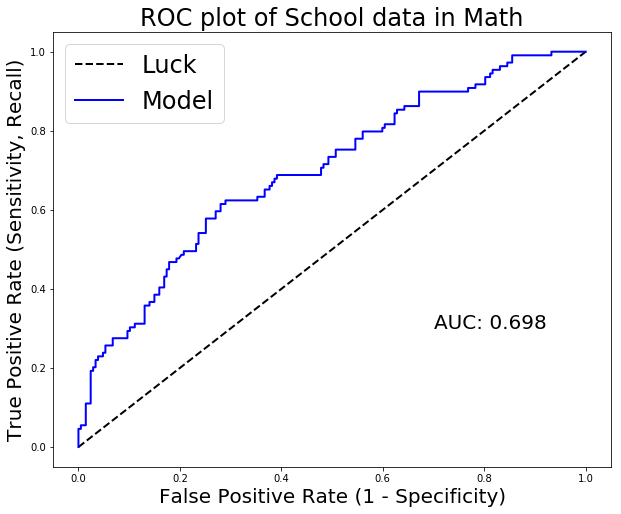

In [92]:
m_prob1, m_auc1, m_fpr1, m_tpr1 = run_data('m_train_roc''math', 'train', m_best_penalty, m_best_c, X_m3, X_test_m, y_m, y_test_m)

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


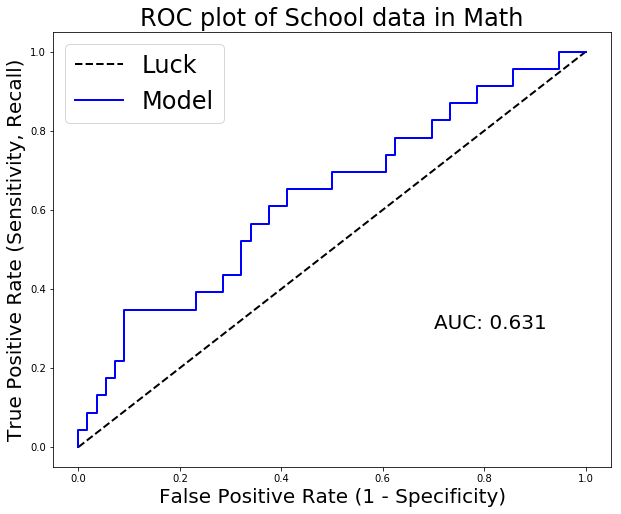

In [93]:
m_prob2, m_auc2, m_fpr2, m_tpr2 = run_data('math', 'test', m_best_penalty, m_best_c, X_m3, X_test_m, y_m, y_test_m)

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


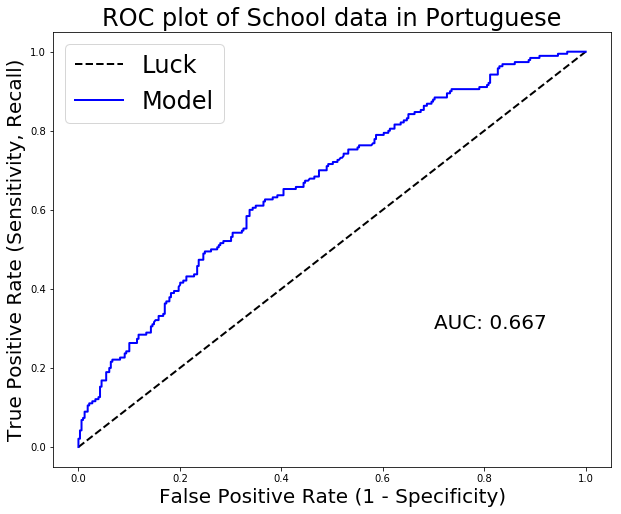

In [94]:
p_prob1, p_auc1, p_fpr1, p_tpr1 = run_data('port', 'train', p_best_penalty, p_best_c, X_p3, X_test_p, y_p, y_test_p)

/Users/tsandefer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


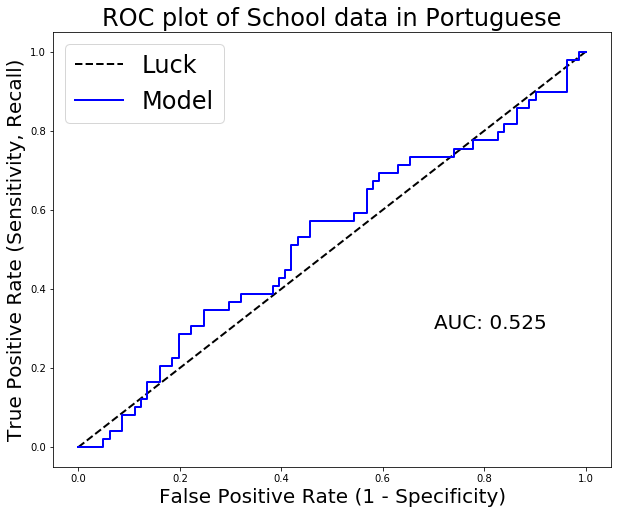

In [95]:
p_prob2, p_auc2, p_fpr2, p_tpr2 = run_data('port', 'test', p_best_penalty, p_best_c, X_p3, X_test_p, y_p, y_test_p)

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, ax, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    font_size = 24
    p = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title,fontsize=font_size)
    
    plt.colorbar(p)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center", size = font_size,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    ax.set_ylabel('True label',fontsize=font_size)
    ax.set_xlabel('Predicted label',fontsize=font_size)

In [ ]:
threas = 0.5

m_pred1 = np.where(m_prob1 >= threas, 1, 0)
p_pred1 = np.where(p_prob1 >= threas, 1, 0)
m_pred2 = np.where(m_prob2 >= threas, 1, 0)
p_pred2 = np.where(p_prob2 >= threas, 1, 0)

In [ ]:
m_cfm1 = confusion_matrix(m_pred1, y_m.values)
sns.heatmap(m_cfm1, annot=True)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')

In [ ]:
m_cfm2 = confusion_matrix(m_pred2, y_test_m.values)
sns.heatmap(m_cfm2, annot=True)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')

In [ ]:
p_cfm1 = confusion_matrix(p_pred1, y_p.values)
sns.heatmap(p_cfm1, annot=True)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')

In [ ]:
p_cfm2 = confusion_matrix(p_pred2, y_test_p.values)
sns.heatmap(p_cfm2, annot=True)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')

In [ ]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
ax.grid(False)
class_names = ["in relationship","single"]
plot_confusion_matrix(cnf_matrix, ax, classes=class_names,normalize=False,
                      title='Math Confusion matrix, threshold = 0.7')

In [ ]:
clf = LogisticRegressionCV(cv=RepeatedStratifiedKFold(), penalty='l2', scoring='accuracy', class_weight='balanced', random_state=0)

m_model = clf.fit(X_m, y_m)
#p_model = clf.fit(X_p, y_p)

#m_clf.predict(X_m)

# set threshold...
m_thresh = 0.7 

m_probs = m_model.predict_proba(X_m)

m_labels = np.where(m_probs >= m_thresh, 1, 0)

acc_m = m_model.score(X_m, y_m)

print("Accuracy: {}".format(acc_m))